<a href="https://colab.research.google.com/github/juampi20/artificial-intelligence-2022/blob/master/tp4_juanpablogarcia_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='lightblue'>Computer Vision</font>

En este notebook veremos como implementar una arquitectura de red para procesar imágenes y que aprenda a obtener patrones (pixeles) que le sirvan para hacer una clasificación.

Usaremos el dataset [Food101](https://www.kaggle.com/datasets/dansbecker/food-101) para distintas tareas. Espero que no les de hambre xd.

Veremos:
1. Clasificación binaria (sigmoid).
2. Clasificación multi-clase (softmax/argmax).
3. Transfer Learning.

## 1. Clasificación binaria de imágenes

Primero cargamos el dataset que contiene solo imágenes de pizzas y steaks(carne) para entrenar una red neuronal convolucional para clasificación binaria.



### Cargamos el dataset

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

--2022-11-04 05:15:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 74.125.24.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  15.1MB/s    in 8.3s    

2022-11-04 05:15:33 (12.6 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [ ]:
!nvidia-smi

Fri Nov  4 05:15:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Extraemos del archivo zip las carpetas
import zipfile
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

>**Nota:** La estructura de carpetas bajo el nombre de train o test y luego bajo el nombre de pizza o steak en cada caso, es el tipo de estructura que necesita `TensorFlow` para saber cual es la carpeta de entrenamiento y testeo, y cual es la clase (etiqueta) de cada grupo de imagen. Con esta clase que encuentra en el nombre de la carpeta es la que va a utilizar para entrenarse.

In [ ]:
import os
os.listdir('pizza_steak/test/pizza')

['346091.jpg',
 '728260.jpg',
 '2782998.jpg',
 '678708.jpg',
 '2615100.jpg',
 '3282393.jpg',
 '3092704.jpg',
 '419962.jpg',
 '3612981.jpg',
 '1925494.jpg',
 '96357.jpg',
 '61656.jpg',
 '324942.jpg',
 '3724187.jpg',
 '153195.jpg',
 '1152100.jpg',
 '3827990.jpg',
 '1179703.jpg',
 '139987.jpg',
 '2236338.jpg',
 '3785667.jpg',
 '343480.jpg',
 '1342321.jpg',
 '1484836.jpg',
 '248199.jpg',
 '3281205.jpg',
 '1691503.jpg',
 '2101820.jpg',
 '971934.jpg',
 '3296907.jpg',
 '1999711.jpg',
 '2161321.jpg',
 '1180273.jpg',
 '2111981.jpg',
 '513415.jpg',
 '556507.jpg',
 '212995.jpg',
 '3486640.jpg',
 '2019408.jpg',
 '380739.jpg',
 '976107.jpg',
 '1398213.jpg',
 '2478221.jpg',
 '1506213.jpg',
 '80750.jpg',
 '2944567.jpg',
 '2870405.jpg',
 '1687143.jpg',
 '3784357.jpg',
 '2398925.jpg',
 '2880804.jpg',
 '1315645.jpg',
 '729262.jpg',
 '666569.jpg',
 '3724416.jpg',
 '22489.jpg',
 '129666.jpg',
 '1986128.jpg',
 '3475871.jpg',
 '395662.jpg',
 '53217.jpg',
 '98607.jpg',
 '1380247.jpg',
 '2320458.jpg',
 '44810

In [ ]:
# Exploramos las carpetas un poco...
import os

for dir, dirname, files in os.walk('pizza_steak'):
  print(f"Dir: {dir} | subdir: {dirname} | cant de imagenes: {len(files)} ")

Dir: pizza_steak | subdir: ['train', 'test'] | cant de imagenes: 0 
Dir: pizza_steak/train | subdir: ['pizza', 'steak'] | cant de imagenes: 0 
Dir: pizza_steak/train/pizza | subdir: [] | cant de imagenes: 750 
Dir: pizza_steak/train/steak | subdir: [] | cant de imagenes: 750 
Dir: pizza_steak/test | subdir: ['pizza', 'steak'] | cant de imagenes: 0 
Dir: pizza_steak/test/pizza | subdir: [] | cant de imagenes: 250 
Dir: pizza_steak/test/steak | subdir: [] | cant de imagenes: 250 


Vemos que la carpeta `train` contiene 750 imágenes de pizza y 750 de steak.

La carpeta `test` contiene 250 imágenes de pizza y 250 imágenes de steak.

In [ ]:
#Guardamos el nombre de las carpetas que haya dentro de train en una lista
# se puede hacer a mano pero a veces son muchas y podemos cometer errores.

classes = [f for f in os.listdir('pizza_steak/train/')]
print(classes)

['pizza', 'steak']


### Visualizamos algunos ejemplos del dataset

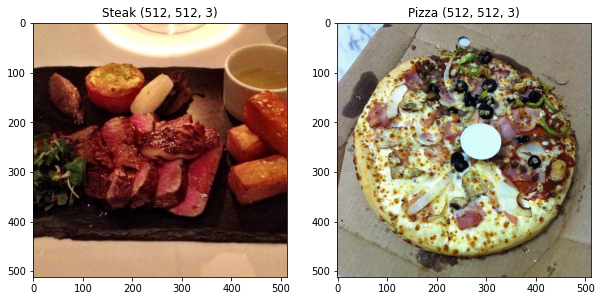

In [ ]:
import matplotlib.pyplot as plt
import random 

plt.figure(figsize=(10,7))
id = random.choice(range(0,749))
plt.subplot(1,2,1)
img_name = [f for f in os.listdir('pizza_steak/train/steak/')][id]
img = plt.imread('pizza_steak/train/steak/'+img_name)
plt.imshow(img)
plt.title('Steak '+str(img.shape))
plt.subplot(1,2,2)
img_name = [f for f in os.listdir('pizza_steak/train/pizza/')][id]
img = plt.imread('pizza_steak/train/pizza/'+img_name)
plt.imshow(img)
plt.title('Pizza '+str(img.shape));

In [ ]:
#Exploramos los características de las imágenes
lista_img_pizza = [f for f in os.listdir('pizza_steak/train/pizza/')]
imagen_prueba = plt.imread('pizza_steak/train/pizza/'+lista_img_pizza[23]) #Elegimos la primera de las imágenes de la lista para leerlas
print(f"Shape de la imagen: {imagen_prueba.shape}")
print(f"Dimensiones de la imagen: {imagen_prueba.ndim}")
print(f"Codificación la imagen: {imagen_prueba.dtype}")
print(f"Pixel de mayor valor: {imagen_prueba.max()}")
print(f"Pixel de menor valor: {imagen_prueba.min()}")

Shape de la imagen: (512, 512, 3)
Dimensiones de la imagen: 3
Codificación la imagen: uint8
Pixel de mayor valor: 255
Pixel de menor valor: 0


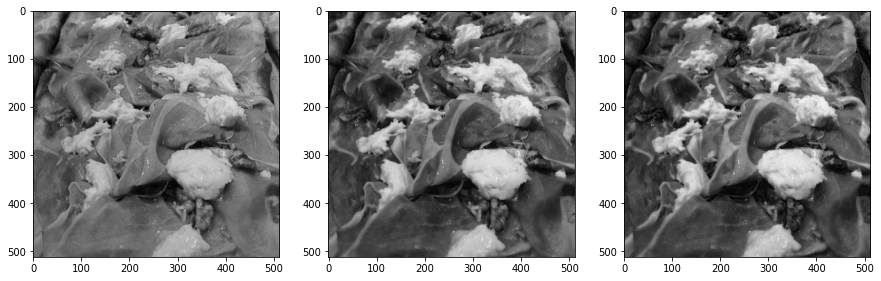

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
plt.imshow(imagen_prueba[:,:,0],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(imagen_prueba[:,:,1],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(imagen_prueba[:,:,2],cmap='gray');

### Creamos la arquitectura de una red neuronal convolucional
Vamos a construir una red neuronal convolucional para encontrar patrones en nuestras imágenes, más específicamente, necesitamos una forma de:
* Cargar la imágenes con TensorFlow
* Preprocesar las imágenes para escalarlas.
* Construir la red convolucional para clasificación
* Compilar la CNN
* Entrenar la CNN con los datos de entrenamiento. 

In [ ]:
# Primero instanciamos el generador de dataset
# Este lo que hace es permitirnos preprocesar las imagenes (rescalarlas y aplicarles tecnicas de data augmentation)
import tensorflow as tf
tf.random.set_seed(42) #usamos este seed para que cada vez que ejecutemos la celda nos repetira los mismos valores, se usa mucho cuando queremos replicar experimentos

train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batch = train_generator.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='binary') #multiclass -> 'categorical' [001,100,010]
test_batch = test_generator.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='binary')


In [ ]:
imagenes, etiquetas = train_batch[0]
print(len(imagenes),len(etiquetas))

In [ ]:
classes

In [ ]:
etiquetas

In [ ]:
import tensorflow as tf
#Creamos la red convolucional 

model_0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_0.summary()

In [ ]:
#Creamos la red convolucional 

model_0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])), 
    tf.keras.layers.Conv2D(5, kernel_size=(3,3), activation='relu'), #Conv -> Maxpooling -> Conv -> Maxpooling -> Flatten(vectorización) -> DNN 
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(5, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout((0.20)),
    tf.keras.layers.Conv2D(5, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_0.summary()

In [ ]:
## Compilamos el modelo
model_0.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = ['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
## Entrenamos el modelo
model_0.fit(train_batch,
            epochs=100,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.ModelCheckpoint('checkpoints/model_0',save_best_only=True),
                         tf.keras.callbacks.TensorBoard('logs/model_0'),
                         tf.keras.callbacks.EarlyStopping(patience=10)])

### Evaluamos el modelo

Para esto vamos a importarlo de la carpeta donde se guardaron los checkpoints.

In [ ]:
model_0 = tf.keras.models.load_model('/content/checkpoints/model_0')

In [ ]:
model_0.evaluate(test_batch)

In [ ]:
# Podemos ver las métricas con TensorBoard que guardamos durante el entrenamiento
!tensorboard dev upload --logdir=logs/model_0  #tensorboard --logdir=

### Hacemos una predicción

In [ ]:
# Elegimos una imagen de dataset a gusto
img = plt.imread('/content/pizza_steak/test/pizza/1180273.jpg')

#Rescalamos la imagen para introducirla al modelo
img = img/255.
# Tensorflow usa float16 / float32

#Ajustamos la imagen a 224,224,3

img.resize((224,224,3))
img_expanded = tf.expand_dims(img, axis=0) # TensorFlow (None, 224, 224 ,3) np.expand_dims(img,axis=0)

y_pred = model_0.predict(img_expanded)
print(y_pred)

In [ ]:
# A la salida del modelo le quitamos la dimensión extra que tiene y redondeamos el valor a la clase más cercana (en este caso 0)
y_pred = tf.squeeze(y_pred) # Eliminar dimensiones vacias [[0.005]] -> [0.005]
y_pred = tf.round(y_pred)
print(f"La predicción para la imagen de pizza es: {y_pred} ")

In [ ]:
classes

## Ejercicio 1

### 🛠️ Ajustamos los hiperparametros para mejorar las métricas del modelo con el set de testeo 🤓

Acá podemos probar de cambiar algunos hiperparámetros:
1. La cantidad de filtros de las capas convolucionales pueden ir creciendo (16, 32,64)
2. El tamaño del kernel de los filtros también puede crecer 7x7, 9x7, 11x11.
3. Podemos implementar data augmentation.
4. Podemos usar dropout en la red profunda.
5. Podemos cambiar el learning rate.

### Cargamos el dataset

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

--2022-11-04 03:44:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  24.0MB/s    in 5.4s    

2022-11-04 03:44:19 (19.2 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [ ]:
## Extraemos del archivo zip las carpetas
import zipfile
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Exploramos las carpetas un poco...
import os

for dir, dirname, files in os.walk('pizza_steak'):
  print(f"Dir: {dir} | subdir: {dirname} | cant de imagenes: {len(files)} ")

Dir: pizza_steak | subdir: ['train', 'test'] | cant de imagenes: 0 
Dir: pizza_steak/train | subdir: ['pizza', 'steak'] | cant de imagenes: 0 
Dir: pizza_steak/train/pizza | subdir: [] | cant de imagenes: 750 
Dir: pizza_steak/train/steak | subdir: [] | cant de imagenes: 750 
Dir: pizza_steak/test | subdir: ['pizza', 'steak'] | cant de imagenes: 0 
Dir: pizza_steak/test/pizza | subdir: [] | cant de imagenes: 250 
Dir: pizza_steak/test/steak | subdir: [] | cant de imagenes: 250 


In [ ]:
import os
# Guardamos el nombre de las carpetas que haya dentro de train en una lista
# se puede hacer a mano pero a veces son muchas y podemos cometer errores.

classes = [f for f in os.listdir('pizza_steak/train/')]
print(classes)

['pizza', 'steak']


### Creamos la arquitectura de una red neuronal convolucional

In [ ]:
# Primero instanciamos el generador de dataset
# Este lo que hace es permitirnos preprocesar las imagenes (rescalarlas y aplicarles tecnicas de data augmentation)
import tensorflow as tf
tf.random.set_seed(42) #usamos este seed para que cada vez que ejecutemos la celda nos repetira los mismos valores, se usa mucho cuando queremos replicar experimentos

train_dir = '/content/pizza_steak/train'
test_dir = '/content/pizza_steak/test'

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batch = train_generator.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='binary')
test_batch = test_generator.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='binary')

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
#Creamos la red convolucional 

exercise_model_0 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])), 
    tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
exercise_model_0.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 flatten_3 (Flatten)         (None, 173056)           

In [ ]:
## Compilamos el modelo
exercise_model_0.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.BinaryCrossentropy(),
                metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
## Entrenamos el modelo
exercise_model_0.fit(train_batch,
            epochs=100,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.ModelCheckpoint('checkpoints/exercise_model_0',save_best_only=True),
                         tf.keras.callbacks.TensorBoard('logs/exercise_model_0'),
                         tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9160 - precision_2: 0.9216 - recall_2: 0.9093

47/47 [==============================] - 12s 239ms/step - loss: 0.2205 - accuracy: 0.9160 - precision_2: 0.9216 - recall_2: 0.9093 - val_loss: 0.2969 - val_accuracy: 0.8640 - val_precision_2: 0.9252 - val_recall_2: 0.7920
Epoch 2/100
47/47 [==============================] - 11s 232ms/step - loss: 0.1788 - accuracy: 0.9340 - precision_2: 0.9357 - recall_2: 0.9320 - val_loss: 0.3652 - val_accuracy: 0.8320 - val_precision_2: 0.7804 - val_recall_2: 0.9240
Epoch 3/100
47/47 [==============================] - 9s 197ms/step - loss: 0.1479 - accuracy: 0.9527 - precision_2: 0.9569 - recall_2: 0.9480 - val_loss: 0.3113 - val_accuracy: 0.8620 - val_precision_2: 0.8494 - val_recall_2: 0.8800
Epoch 4/100
47/47 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.9467 - precision_2: 0.9527 - recall_2: 0.9400

47/47 [==============================] - 11s 226ms/step - loss: 0.1587 - accuracy: 0.9467 - precision_2: 0.9527 - recall_2: 0.9400 - val_loss: 0.2789 - val_accuracy: 0.8960 - val_precision_2: 0.9231 - val_recall_2: 0.8640
Epoch 5/100
47/47 [==============================] - 9s 195ms/step - loss: 0.1089 - accuracy: 0.9647 - precision_2: 0.9678 - recall_2: 0.9613 - val_loss: 0.3850 - val_accuracy: 0.8520 - val_precision_2: 0.9151 - val_recall_2: 0.7760
Epoch 6/100
47/47 [==============================] - 9s 197ms/step - loss: 0.1173 - accuracy: 0.9667 - precision_2: 0.9692 - recall_2: 0.9640 - val_loss: 0.4932 - val_accuracy: 0.8000 - val_precision_2: 0.9412 - val_recall_2: 0.6400
Epoch 7/100
47/47 [==============================] - 9s 195ms/step - loss: 0.0894 - accuracy: 0.9673 - precision_2: 0.9680 - recall_2: 0.9667 - val_loss: 0.2974 - val_accuracy: 0.8780 - val_precision_2: 0.8826 - val_recall_2: 0.8720
Epoch 8/100
47/47 [==============================] - 9s 193ms/step - loss: 0.07

### Evaluamos el modelo

In [ ]:
exercise_model_0 = tf.keras.models.load_model('/content/checkpoints/exercise_model_0')

In [ ]:
exercise_model_0.evaluate(test_batch)

16/16 [==============================] - 2s 134ms/step - loss: 0.2789 - accuracy: 0.8960 - precision_2: 0.9231 - recall_2: 0.8640


[0.27894848585128784,
 0.8960000276565552,
 0.9230769276618958,
 0.8640000224113464]

In [ ]:
# Podemos ver las métricas con TensorBoard que guardamos durante el entrenamiento
!tensorboard dev upload --logdir=logs/exercise_model_0

Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/2SWvnuz8R7WakfM1RnMSEg/

[2022-11-04T04:17:24] Started scanning logdir.
E1104 04:17:26.583089 140129951975296 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
[2022-11-04T04:17:26] Total uploaded: 420 scalars, 0 tensors, 1 binary objects (88.6 kB)
Total skipped: 1 binary objects (88.6 kB)
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  F

### Hacemos una predicción

In [ ]:
import matplotlib.pyplot as plt
# Elegimos una imagen de dataset a gusto
img = plt.imread('/content/pizza_steak/test/pizza/1180273.jpg')

#Rescalamos la imagen para introducirla al modelo
img = img/255.
# Tensorflow usa float16 / float32

#Ajustamos la imagen a 224,224,3

img.resize((224,224,3))
img_expanded = tf.expand_dims(img, axis=0) # TensorFlow (None, 224, 224 ,3) np.expand_dims(img,axis=0)

y_pred = model_0.predict(img_expanded)
print(y_pred)

1/1 [==============================] - 0s 191ms/step
[[0.2977634]]


In [ ]:
# A la salida del modelo le quitamos la dimensión extra que tiene y redondeamos el valor a la clase más cercana (en este caso 0)
y_pred = tf.squeeze(y_pred) # Eliminar dimensiones vacias [[0.005]] -> [0.005]
y_pred = tf.round(y_pred)
print(f"La predicción para la imagen de pizza es: {y_pred} ")

La predicción para la imagen de pizza es: 0.0 


In [ ]:
classes

['pizza', 'steak']

> **Observacion:** Con la mejora del modelo se logro una mejor precision, dandonos una prediccion un poco mas acertada.



---



## 2. Clasificación multiclase de imágenes

Para este ejercicio tomaremos 10 comidas del mismo dataset original.

Lo importamos en formato zip, por lo que despues lo descomprimimos usando `zipfile`.

Para este ejercicio deberán seguir los siguientes pasos:
1. Convertirse uno con los datos. Es decir, exploren a fondo el dataset para tener un entendimiento total.
2. Preprocesar los datos.
3. Crear un modelo.
4. Compilar el modelo
5. Entrenar el modelo.
6. Evaluar el modelo.
7. Ajustar diferentes hiperparámetros y mejorar el modelo (intentar superar las metricas que ya se tienen y reducir el sobreajuste).
8. Repetir los pasos hasta que las metricas sean las deseadas.

### Cargamos el dataset

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2022-10-04 00:03:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   142MB/s    in 3.5s    

2022-10-04 00:03:21 (142 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
## Extraemos del archivo zip las carpetas
import zipfile
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Exploramos las carpetas...
import os
for dir, dirname, files in os.walk('10_food_classes_all_data'):
  print(f"Dir: {dir} | subdir: {dirname} | cant de imagenes: {len(files)} ")

Dir: 10_food_classes_all_data | subdir: ['test', 'train'] | cant de imagenes: 0 
Dir: 10_food_classes_all_data/test | subdir: ['grilled_salmon', 'hamburger', 'steak', 'chicken_curry', 'pizza', 'chicken_wings', 'ramen', 'ice_cream', 'fried_rice', 'sushi'] | cant de imagenes: 0 
Dir: 10_food_classes_all_data/test/grilled_salmon | subdir: [] | cant de imagenes: 250 
Dir: 10_food_classes_all_data/test/hamburger | subdir: [] | cant de imagenes: 250 
Dir: 10_food_classes_all_data/test/steak | subdir: [] | cant de imagenes: 250 
Dir: 10_food_classes_all_data/test/chicken_curry | subdir: [] | cant de imagenes: 250 
Dir: 10_food_classes_all_data/test/pizza | subdir: [] | cant de imagenes: 250 
Dir: 10_food_classes_all_data/test/chicken_wings | subdir: [] | cant de imagenes: 250 
Dir: 10_food_classes_all_data/test/ramen | subdir: [] | cant de imagenes: 250 
Dir: 10_food_classes_all_data/test/ice_cream | subdir: [] | cant de imagenes: 250 
Dir: 10_food_classes_all_data/test/fried_rice | subdir: [

Vemos que la carpeta `train` contiene 750 imágenes de cada clase: ['sushi', 'chicken_wings', 'chicken_curry', 'pizza', 'hamburger', 'grilled_salmon', 'fried_rice', 'steak', 'ice_cream', 'ramen']

La carpeta `test` contiene 250 imágenes de cada clase: ['sushi', 'chicken_wings', 'chicken_curry', 'pizza', 'hamburger', 'grilled_salmon', 'fried_rice', 'steak', 'ice_cream', 'ramen']

In [ ]:
classes = [f for f in os.listdir('10_food_classes_all_data/train')]
print(classes)

['grilled_salmon', 'hamburger', 'steak', 'chicken_curry', 'pizza', 'chicken_wings', 'ramen', 'ice_cream', 'fried_rice', 'sushi']


### Visualizamos algunos ejemplos del dataset

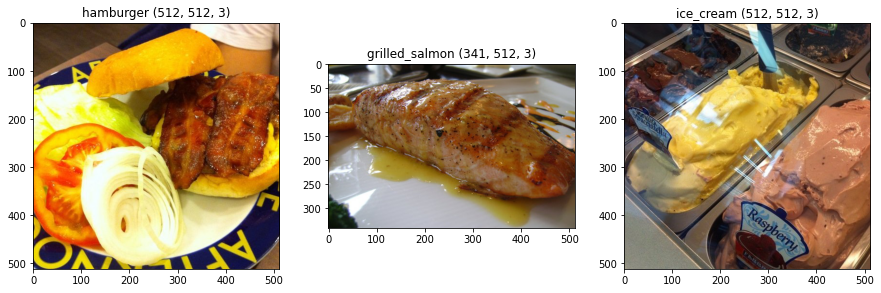

In [ ]:
import matplotlib.pyplot as plt
import random 

plt.figure(figsize=(15,7))
id = random.choice(range(0,749))
plt.subplot(1,3,1)
img_name = [f for f in os.listdir('10_food_classes_all_data/train/hamburger')][id]
img = plt.imread('10_food_classes_all_data/train/hamburger/'+img_name)
plt.imshow(img)
plt.title('hamburger '+str(img.shape))
plt.subplot(1,3,2)
img_name = [f for f in os.listdir('10_food_classes_all_data/train/grilled_salmon/')][id]
img = plt.imread('10_food_classes_all_data/train/grilled_salmon/'+img_name)
plt.imshow(img)
plt.title('grilled_salmon '+str(img.shape))
plt.subplot(1,3,3)
img_name = [f for f in os.listdir('10_food_classes_all_data/train/ice_cream/')][id]
img = plt.imread('10_food_classes_all_data/train/ice_cream/'+img_name)
plt.imshow(img)
plt.title('ice_cream '+str(img.shape));

In [ ]:
#Exploramos los características de las imágenes
lista_img_pizza = [f for f in os.listdir('10_food_classes_all_data/train/hamburger/')]
imagen_prueba = plt.imread('10_food_classes_all_data/train/hamburger/'+random.choice(lista_img_pizza)) #Elegimos la primera de las imágenes de la lista para leerlas
print(f"Shape de la imagen: {imagen_prueba.shape}")
print(f"Dimensiones de la imagen: {imagen_prueba.ndim}")
print(f"Codificación la imagen: {imagen_prueba.dtype}")
print(f"Pixel de mayor valor: {imagen_prueba.max()}")
print(f"Pixel de menor valor: {imagen_prueba.min()}")

Shape de la imagen: (512, 512, 3)
Dimensiones de la imagen: 3
Codificación la imagen: uint8
Pixel de mayor valor: 255
Pixel de menor valor: 0


### Creamos la arquitectura CNN para multi-clasificación

In [ ]:
import tensorflow as tf
print(f"Version: {tf.__version__}")

Version: 2.8.2


In [ ]:
tf.random.set_seed(42) 

train_dir = '/content/10_food_classes_all_data/train/'
test_dir = '/content/10_food_classes_all_data/test/'

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batch = train_generator.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical') #Usamos categorical para referirnos a que son más de dos clases
test_batch = test_generator.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical') #'sparse'

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
images, etiquetas = train_batch[0]
etiquetas [:5] #ONE HOT ENCODER 

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
#Creamos la red convolucional 

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    tf.keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(10, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),

    tf.keras.layers.Dense(10, activation='softmax')
])
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 flatten_3 (Flatten)         (None, 27040)            

In [ ]:
model_1.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])

In [ ]:
model_1.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=10),
                         tf.keras.callbacks.ReduceLROnPlateau(patience=5)])

Epoch 1/200
235/235 [==============================] - 49s 205ms/step - loss: 2.1663 - accuracy: 0.2167 - val_loss: 2.0315 - val_accuracy: 0.2588 - lr: 0.0010
Epoch 2/200
235/235 [==============================] - 45s 193ms/step - loss: 1.9601 - accuracy: 0.3060 - val_loss: 1.9724 - val_accuracy: 0.3020 - lr: 0.0010
Epoch 3/200
235/235 [==============================] - 46s 197ms/step - loss: 1.8272 - accuracy: 0.3607 - val_loss: 1.8886 - val_accuracy: 0.3220 - lr: 0.0010
Epoch 4/200
235/235 [==============================] - 45s 190ms/step - loss: 1.6411 - accuracy: 0.4395 - val_loss: 1.7888 - val_accuracy: 0.3764 - lr: 0.0010
Epoch 5/200
235/235 [==============================] - 45s 191ms/step - loss: 1.4273 - accuracy: 0.5200 - val_loss: 1.7727 - val_accuracy: 0.3808 - lr: 0.0010
Epoch 6/200
235/235 [==============================] - 46s 195ms/step - loss: 1.1735 - accuracy: 0.6141 - val_loss: 1.8960 - val_accuracy: 0.3776 - lr: 0.0010
Epoch 7/200
235/235 [=========================

### Evaluamos el modelo

In [ ]:
model_1.evaluate(test_batch)

79/79 [==============================] - 11s 144ms/step - loss: 3.2275 - accuracy: 0.3680


[3.2274560928344727, 0.36800000071525574]

### Hacemos una predicción

In [ ]:
# Elegimos una imagen de dataset a gusto
img = plt.imread('/content/10_food_classes_all_data/test/fried_rice/1023430.jpg')

#Rescalamos la imagen para introducirla al modelo
img = img/255.

#Ajustamos la imagen a 224,224,3

img.resize((224,224,3))
img_expanded = tf.expand_dims(img, axis=0)

y_pred = model_1.predict(img_expanded)
print(y_pred) #Softmax

[[1.0302910e-08 2.4684252e-12 1.2947203e-01 1.5090096e-09 7.4921243e-11
  8.7049294e-01 5.8787799e-07 1.1708108e-08 3.4290882e-05 3.5068080e-08]]


In [ ]:
y_pred = tf.squeeze(y_pred)
tf.math.reduce_sum(y_pred).numpy()

0.9999999

In [ ]:
tf.argmax(y_pred).numpy()

5

In [ ]:
y_pred = tf.squeeze(y_pred)
y_pred = tf.round(y_pred)
print(f"La predicción para la imagen de pizza es: {y_pred} ") #ARGMAX

La predicción para la imagen de pizza es: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 


In [ ]:
y_pred = tf.argmax(y_pred) #argmax retorna el indice del item mayor de todos los items
print(f"La clase es: {classes[y_pred]}")

La clase es: chicken_wings


## Ejercicio 2

### 🛠️ Ajustamos los hiperparametros para mejorar las métricas del modelo con el set de testeo 🤓

Acá podemos probar de cambiar algunos hiperparámetros:
1. La cantidad de filtros de las capas convolucionales pueden ir creciendo (16, 32,...)
2. El tamaño del kernel de los filtros también puede crecer.
3. Podemos implementar data augmentation (más tecnicas).
4. Podemos usar dropout en la red profunda.
5. Podemos cambiar el learning rate.

### Cargamos el dataset

In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2022-11-04 08:15:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 172.217.15.80, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   283MB/s    in 1.8s    

2022-11-04 08:15:06 (283 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [2]:
## Extraemos del archivo zip las carpetas
import zipfile
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

In [3]:
# Exploramos las carpetas...
import os
for dir, dirname, files in os.walk('10_food_classes_all_data'):
  print(f"Dir: {dir} | subdir: {dirname} | cant de imagenes: {len(files)} ")

Dir: 10_food_classes_all_data | subdir: ['train', 'test'] | cant de imagenes: 0 
Dir: 10_food_classes_all_data/train | subdir: ['hamburger', 'ice_cream', 'ramen', 'chicken_curry', 'pizza', 'grilled_salmon', 'fried_rice', 'chicken_wings', 'steak', 'sushi'] | cant de imagenes: 0 
Dir: 10_food_classes_all_data/train/hamburger | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/ice_cream | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/ramen | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/chicken_curry | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/pizza | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/grilled_salmon | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/fried_rice | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/chicken_wings | subdir: [] | cant de imagenes: 750 
Dir: 10_food_classes_all_data/train/steak |

In [4]:
classes = [f for f in os.listdir('10_food_classes_all_data/train')]
print(classes)

['hamburger', 'ice_cream', 'ramen', 'chicken_curry', 'pizza', 'grilled_salmon', 'fried_rice', 'chicken_wings', 'steak', 'sushi']


### Creamos la arquitectura CNN para multi-clasificación

In [5]:
# Primero instanciamos el generador de dataset
# Este lo que hace es permitirnos preprocesar las imagenes (rescalarlas y aplicarles tecnicas de data augmentation)
import tensorflow as tf
tf.random.set_seed(42) #usamos este seed para que cada vez que ejecutemos la celda nos repetira los mismos valores, se usa mucho cuando queremos replicar experimentos

train_dir = '/content/10_food_classes_all_data/train/'
test_dir = '/content/10_food_classes_all_data/test/'

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True,
                                                                  vertical_flip=True)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_batch = train_generator.flow_from_directory(train_dir,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')
test_batch = test_generator.flow_from_directory(test_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [6]:
#Creamos la red convolucional 

exercise_model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    tf.keras.layers.Conv2D(32, kernel_size=(11,11), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, kernel_size=(5,5), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])
exercise_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 214, 214, 32)      11648     
                                                                 
 batch_normalization (BatchN  (None, 214, 214, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 107, 107, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 103, 103, 64)      51264     
                                                                 
 batch_normalization_1 (Batc  (None, 103, 103, 64)     256       
 hNormalization)                                                 
                                                        

In [7]:
exercise_model_1.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])

In [8]:
exercise_model_1.fit(train_batch,
            epochs=50,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.ModelCheckpoint('checkpoints/exercise_model_1',save_best_only=True),
                         tf.keras.callbacks.TensorBoard('logs/exercise_model_1'),
                         tf.keras.callbacks.EarlyStopping(patience=10),
                         tf.keras.callbacks.ReduceLROnPlateau(patience=5)])

Epoch 1/50
235/235 [==============================] - ETA: 0s - loss: 2.5080 - accuracy: 0.1519

235/235 [==============================] - 64s 232ms/step - loss: 2.5080 - accuracy: 0.1519 - val_loss: 2.2766 - val_accuracy: 0.1576 - lr: 0.0010
Epoch 2/50
235/235 [==============================] - 50s 213ms/step - loss: 2.2828 - accuracy: 0.1389 - val_loss: 2.3024 - val_accuracy: 0.1520 - lr: 0.0010
Epoch 3/50
235/235 [==============================] - ETA: 0s - loss: 2.2507 - accuracy: 0.1625

235/235 [==============================] - 52s 223ms/step - loss: 2.2507 - accuracy: 0.1625 - val_loss: 2.2061 - val_accuracy: 0.1852 - lr: 0.0010
Epoch 4/50
235/235 [==============================] - ETA: 0s - loss: 2.2224 - accuracy: 0.1656

235/235 [==============================] - 51s 217ms/step - loss: 2.2224 - accuracy: 0.1656 - val_loss: 2.1879 - val_accuracy: 0.1980 - lr: 0.0010
Epoch 5/50
235/235 [==============================] - ETA: 0s - loss: 2.1774 - accuracy: 0.2031

235/235 [==============================] - 50s 214ms/step - loss: 2.1774 - accuracy: 0.2031 - val_loss: 2.0854 - val_accuracy: 0.2348 - lr: 0.0010
Epoch 6/50
235/235 [==============================] - ETA: 0s - loss: 2.1400 - accuracy: 0.2168

235/235 [==============================] - 52s 223ms/step - loss: 2.1400 - accuracy: 0.2168 - val_loss: 1.9524 - val_accuracy: 0.3136 - lr: 0.0010
Epoch 7/50
235/235 [==============================] - 49s 207ms/step - loss: 2.1101 - accuracy: 0.2213 - val_loss: 2.0029 - val_accuracy: 0.2948 - lr: 0.0010
Epoch 8/50
235/235 [==============================] - 50s 214ms/step - loss: 2.1003 - accuracy: 0.2343 - val_loss: 1.9777 - val_accuracy: 0.3108 - lr: 0.0010
Epoch 9/50
235/235 [==============================] - 48s 206ms/step - loss: 2.0740 - accuracy: 0.2527 - val_loss: 1.9908 - val_accuracy: 0.3048 - lr: 0.0010
Epoch 10/50
235/235 [==============================] - 48s 205ms/step - loss: 2.0572 - accuracy: 0.2560 - val_loss: 1.9525 - val_accuracy: 0.3252 - lr: 0.0010
Epoch 11/50
235/235 [==============================] - 48s 205ms/step - loss: 2.0252 - accuracy: 0.2763 - val_loss: 1.9724 - val_accuracy: 0.3084 - lr: 0.0010
Epoch 12/50
235/235 [==============================] - ETA: 0

235/235 [==============================] - 52s 220ms/step - loss: 1.9771 - accuracy: 0.2961 - val_loss: 1.8175 - val_accuracy: 0.3948 - lr: 1.0000e-04
Epoch 13/50
235/235 [==============================] - ETA: 0s - loss: 1.9391 - accuracy: 0.3063

235/235 [==============================] - 51s 218ms/step - loss: 1.9391 - accuracy: 0.3063 - val_loss: 1.8023 - val_accuracy: 0.3964 - lr: 1.0000e-04
Epoch 14/50
235/235 [==============================] - ETA: 0s - loss: 1.9166 - accuracy: 0.3149

235/235 [==============================] - 51s 215ms/step - loss: 1.9166 - accuracy: 0.3149 - val_loss: 1.7950 - val_accuracy: 0.4080 - lr: 1.0000e-04
Epoch 15/50
235/235 [==============================] - ETA: 0s - loss: 1.9064 - accuracy: 0.3177

235/235 [==============================] - 50s 214ms/step - loss: 1.9064 - accuracy: 0.3177 - val_loss: 1.7751 - val_accuracy: 0.4132 - lr: 1.0000e-04
Epoch 16/50
235/235 [==============================] - ETA: 0s - loss: 1.9066 - accuracy: 0.3285

235/235 [==============================] - 50s 213ms/step - loss: 1.9066 - accuracy: 0.3285 - val_loss: 1.7649 - val_accuracy: 0.4192 - lr: 1.0000e-04
Epoch 17/50
235/235 [==============================] - ETA: 0s - loss: 1.8884 - accuracy: 0.3312

235/235 [==============================] - 50s 211ms/step - loss: 1.8884 - accuracy: 0.3312 - val_loss: 1.7466 - val_accuracy: 0.4256 - lr: 1.0000e-04
Epoch 18/50
235/235 [==============================] - ETA: 0s - loss: 1.8758 - accuracy: 0.3341

235/235 [==============================] - 52s 220ms/step - loss: 1.8758 - accuracy: 0.3341 - val_loss: 1.7337 - val_accuracy: 0.4148 - lr: 1.0000e-04
Epoch 19/50
235/235 [==============================] - 50s 211ms/step - loss: 1.8640 - accuracy: 0.3400 - val_loss: 1.7469 - val_accuracy: 0.4196 - lr: 1.0000e-04
Epoch 20/50
235/235 [==============================] - 48s 203ms/step - loss: 1.8628 - accuracy: 0.3388 - val_loss: 1.7412 - val_accuracy: 0.4276 - lr: 1.0000e-04
Epoch 21/50
235/235 [==============================] - ETA: 0s - loss: 1.8501 - accuracy: 0.3500

235/235 [==============================] - 50s 212ms/step - loss: 1.8501 - accuracy: 0.3500 - val_loss: 1.7111 - val_accuracy: 0.4368 - lr: 1.0000e-04
Epoch 22/50
235/235 [==============================] - ETA: 0s - loss: 1.8355 - accuracy: 0.3548

235/235 [==============================] - 50s 211ms/step - loss: 1.8355 - accuracy: 0.3548 - val_loss: 1.7091 - val_accuracy: 0.4344 - lr: 1.0000e-04
Epoch 23/50
235/235 [==============================] - ETA: 0s - loss: 1.8372 - accuracy: 0.3495

235/235 [==============================] - 52s 220ms/step - loss: 1.8372 - accuracy: 0.3495 - val_loss: 1.7024 - val_accuracy: 0.4352 - lr: 1.0000e-04
Epoch 24/50
235/235 [==============================] - ETA: 0s - loss: 1.8188 - accuracy: 0.3568

235/235 [==============================] - 50s 213ms/step - loss: 1.8188 - accuracy: 0.3568 - val_loss: 1.6900 - val_accuracy: 0.4408 - lr: 1.0000e-04
Epoch 25/50
235/235 [==============================] - 50s 213ms/step - loss: 1.8054 - accuracy: 0.3680 - val_loss: 1.6925 - val_accuracy: 0.4408 - lr: 1.0000e-04
Epoch 26/50
235/235 [==============================] - 58s 248ms/step - loss: 1.7766 - accuracy: 0.3863 - val_loss: 1.7062 - val_accuracy: 0.4236 - lr: 1.0000e-04
Epoch 27/50
235/235 [==============================] - ETA: 0s - loss: 1.7764 - accuracy: 0.3753

235/235 [==============================] - 50s 214ms/step - loss: 1.7764 - accuracy: 0.3753 - val_loss: 1.6724 - val_accuracy: 0.4548 - lr: 1.0000e-04
Epoch 28/50
235/235 [==============================] - 50s 213ms/step - loss: 1.7676 - accuracy: 0.3755 - val_loss: 1.6764 - val_accuracy: 0.4428 - lr: 1.0000e-04
Epoch 29/50
235/235 [==============================] - ETA: 0s - loss: 1.7687 - accuracy: 0.3725

235/235 [==============================] - 50s 214ms/step - loss: 1.7687 - accuracy: 0.3725 - val_loss: 1.6589 - val_accuracy: 0.4492 - lr: 1.0000e-04
Epoch 30/50
235/235 [==============================] - 53s 225ms/step - loss: 1.7451 - accuracy: 0.3883 - val_loss: 1.6618 - val_accuracy: 0.4492 - lr: 1.0000e-04
Epoch 31/50
235/235 [==============================] - ETA: 0s - loss: 1.7417 - accuracy: 0.3848

235/235 [==============================] - 51s 218ms/step - loss: 1.7417 - accuracy: 0.3848 - val_loss: 1.6352 - val_accuracy: 0.4516 - lr: 1.0000e-04
Epoch 32/50
235/235 [==============================] - ETA: 0s - loss: 1.7239 - accuracy: 0.3975

235/235 [==============================] - 50s 213ms/step - loss: 1.7239 - accuracy: 0.3975 - val_loss: 1.6217 - val_accuracy: 0.4652 - lr: 1.0000e-04
Epoch 33/50
235/235 [==============================] - 48s 205ms/step - loss: 1.7227 - accuracy: 0.3948 - val_loss: 1.6308 - val_accuracy: 0.4644 - lr: 1.0000e-04
Epoch 34/50
235/235 [==============================] - ETA: 0s - loss: 1.6944 - accuracy: 0.4089

235/235 [==============================] - 52s 219ms/step - loss: 1.6944 - accuracy: 0.4089 - val_loss: 1.6081 - val_accuracy: 0.4684 - lr: 1.0000e-04
Epoch 35/50
235/235 [==============================] - 48s 204ms/step - loss: 1.6947 - accuracy: 0.4120 - val_loss: 1.6272 - val_accuracy: 0.4644 - lr: 1.0000e-04
Epoch 36/50
235/235 [==============================] - ETA: 0s - loss: 1.6694 - accuracy: 0.4229

235/235 [==============================] - 51s 219ms/step - loss: 1.6694 - accuracy: 0.4229 - val_loss: 1.6034 - val_accuracy: 0.4672 - lr: 1.0000e-04
Epoch 37/50
235/235 [==============================] - 47s 201ms/step - loss: 1.6552 - accuracy: 0.4280 - val_loss: 1.6043 - val_accuracy: 0.4628 - lr: 1.0000e-04
Epoch 38/50
235/235 [==============================] - ETA: 0s - loss: 1.6550 - accuracy: 0.4243

235/235 [==============================] - 49s 209ms/step - loss: 1.6550 - accuracy: 0.4243 - val_loss: 1.5816 - val_accuracy: 0.4740 - lr: 1.0000e-04
Epoch 39/50
235/235 [==============================] - 48s 203ms/step - loss: 1.6406 - accuracy: 0.4364 - val_loss: 1.5820 - val_accuracy: 0.4796 - lr: 1.0000e-04
Epoch 40/50
235/235 [==============================] - ETA: 0s - loss: 1.6358 - accuracy: 0.4344

235/235 [==============================] - 51s 217ms/step - loss: 1.6358 - accuracy: 0.4344 - val_loss: 1.5781 - val_accuracy: 0.4804 - lr: 1.0000e-04
Epoch 41/50
235/235 [==============================] - 48s 202ms/step - loss: 1.6094 - accuracy: 0.4381 - val_loss: 1.6340 - val_accuracy: 0.4516 - lr: 1.0000e-04
Epoch 42/50
235/235 [==============================] - ETA: 0s - loss: 1.5925 - accuracy: 0.4511

235/235 [==============================] - 51s 218ms/step - loss: 1.5925 - accuracy: 0.4511 - val_loss: 1.5467 - val_accuracy: 0.4876 - lr: 1.0000e-04
Epoch 43/50
235/235 [==============================] - ETA: 0s - loss: 1.5871 - accuracy: 0.4487

235/235 [==============================] - 50s 211ms/step - loss: 1.5871 - accuracy: 0.4487 - val_loss: 1.5353 - val_accuracy: 0.4980 - lr: 1.0000e-04
Epoch 44/50
235/235 [==============================] - 48s 203ms/step - loss: 1.5770 - accuracy: 0.4539 - val_loss: 1.5700 - val_accuracy: 0.4680 - lr: 1.0000e-04
Epoch 45/50
235/235 [==============================] - 48s 204ms/step - loss: 1.5583 - accuracy: 0.4629 - val_loss: 1.5583 - val_accuracy: 0.4884 - lr: 1.0000e-04
Epoch 46/50
235/235 [==============================] - 50s 211ms/step - loss: 1.5462 - accuracy: 0.4672 - val_loss: 1.5724 - val_accuracy: 0.4940 - lr: 1.0000e-04
Epoch 47/50
235/235 [==============================] - ETA: 0s - loss: 1.5356 - accuracy: 0.4676

235/235 [==============================] - 50s 211ms/step - loss: 1.5356 - accuracy: 0.4676 - val_loss: 1.5166 - val_accuracy: 0.5016 - lr: 1.0000e-04
Epoch 48/50
235/235 [==============================] - 50s 211ms/step - loss: 1.5291 - accuracy: 0.4732 - val_loss: 1.5494 - val_accuracy: 0.4896 - lr: 1.0000e-04
Epoch 49/50
235/235 [==============================] - 48s 203ms/step - loss: 1.5167 - accuracy: 0.4745 - val_loss: 1.5267 - val_accuracy: 0.4996 - lr: 1.0000e-04
Epoch 50/50
235/235 [==============================] - ETA: 0s - loss: 1.5062 - accuracy: 0.4745

235/235 [==============================] - 50s 211ms/step - loss: 1.5062 - accuracy: 0.4745 - val_loss: 1.5081 - val_accuracy: 0.5056 - lr: 1.0000e-04


### Evaluamos el modelo

In [9]:
# Evaluate the model
loss, acc = exercise_model_1.evaluate(test_batch)
print("Trained model, accuracy: {:5.2f}%".format(100 * acc))

79/79 [==============================] - 11s 141ms/step - loss: 1.5081 - accuracy: 0.5056
Trained model, accuracy: 50.56%


### Hacemos una predicción

In [15]:
import matplotlib.pyplot as plt
# Elegimos una imagen de dataset a gusto
img = plt.imread('/content/10_food_classes_all_data/test/fried_rice/1023430.jpg')

#Rescalamos la imagen para introducirla al modelo
img = img/255.

#Ajustamos la imagen a 224,224,3

img.resize((224,224,3))
img_expanded = tf.expand_dims(img, axis=0)

y_pred = exercise_model_1.predict(img_expanded)
print(y_pred) #Softmax

1/1 [==============================] - 0s 16ms/step
[[0.0062549  0.009213   0.33494872 0.00322637 0.00500732 0.58641773
  0.04692387 0.00227254 0.0028132  0.00292235]]


In [16]:
y_pred = tf.squeeze(y_pred)
tf.math.reduce_sum(y_pred).numpy()

1.0

In [17]:
tf.argmax(y_pred).numpy()

5

In [18]:
y_pred = tf.squeeze(y_pred)
y_pred = tf.round(y_pred)
print(f"La predicción para la imagen de fried_rice es: {y_pred} ") #ARGMAX

La predicción para la imagen de fried_rice es: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 


In [19]:
y_pred = tf.argmax(y_pred) #argmax retorna el indice del item mayor de todos los items
print(f"La clase es: {classes[y_pred]}")

La clase es: grilled_salmon




---



## 3. Transfer Learning

O también conocido cómo `fine tuning` es el método por el cual instanciamos una red neuronal convolucional previamente entrenada para otra tarea, pero sus filtros de más bajo nivel sirven para muchos propositos.

Nosotros tomamos esa CNN y re-entrenamos sus capas de más alto nivel para el objetivo que queremos lograr (por ejemplo clasificar comida en imágenes).

Para esto `keras` ya tiene implementado varios arquitecturas pre-entrenadas, las más conocidas son:

* AlexNet
* VGG 16
* VGG 19
* Inception
* ResNet
* EfficientNet


In [ ]:
base_model = tf.keras.applications.VGG19(include_top=False, #sin la parte dnn
                                         weights='imagenet') #EfficienteNetB0
base_model.trainable = False

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer_num, layers in enumerate(base_model.layers):
  print(layer_num, layers)

0 <keras.engine.input_layer.InputLayer object at 0x7fc450707d50>
1 <keras.layers.convolutional.Conv2D object at 0x7fc4506c3b50>
2 <keras.layers.convolutional.Conv2D object at 0x7fc450707790>
3 <keras.layers.pooling.MaxPooling2D object at 0x7fc451c79190>
4 <keras.layers.convolutional.Conv2D object at 0x7fc561246550>
5 <keras.layers.convolutional.Conv2D object at 0x7fc45a300d10>
6 <keras.layers.pooling.MaxPooling2D object at 0x7fc451c7af90>
7 <keras.layers.convolutional.Conv2D object at 0x7fc451c02550>
8 <keras.layers.convolutional.Conv2D object at 0x7fc45a030e50>
9 <keras.layers.convolutional.Conv2D object at 0x7fc451c047d0>
10 <keras.layers.convolutional.Conv2D object at 0x7fc451c0ca50>
11 <keras.layers.pooling.MaxPooling2D object at 0x7fc4507f7a90>
12 <keras.layers.convolutional.Conv2D object at 0x7fc451c13150>
13 <keras.layers.convolutional.Conv2D object at 0x7fc451c1d190>
14 <keras.layers.convolutional.Conv2D object at 0x7fc451c04450>
15 <keras.layers.convolutional.Conv2D object at 

In [ ]:
#Creamos la red convolucional 

model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=([224,224,3])),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, None, None, 512)   20024384  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               6422784   
                                                                 
 dense_11 (Dense)            (None, 10)                2570      
                                                                 
Total params: 26,449,738
Trainable params: 6,425,354
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model_2.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = tf.keras.losses.CategoricalCrossentropy(),
                metrics = ['accuracy'])
model_2.fit(train_batch,
            epochs=200,
            validation_data = test_batch,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/200
235/235 [==============================] - 70s 282ms/step - loss: 1.8654 - accuracy: 0.4673 - val_loss: 1.1449 - val_accuracy: 0.6096
Epoch 2/200
235/235 [==============================] - 63s 268ms/step - loss: 1.0593 - accuracy: 0.6496 - val_loss: 1.0418 - val_accuracy: 0.6408
Epoch 3/200
235/235 [==============================] - 62s 266ms/step - loss: 0.8417 - accuracy: 0.7239 - val_loss: 0.9849 - val_accuracy: 0.6680
Epoch 4/200
235/235 [==============================] - 63s 268ms/step - loss: 0.7064 - accuracy: 0.7708 - val_loss: 1.1766 - val_accuracy: 0.6248
Epoch 5/200
235/235 [==============================] - 65s 277ms/step - loss: 0.6011 - accuracy: 0.8047 - val_loss: 1.1061 - val_accuracy: 0.6372
Epoch 6/200
235/235 [==============================] - 66s 280ms/step - loss: 0.4873 - accuracy: 0.8395 - val_loss: 1.0737 - val_accuracy: 0.6516
Epoch 7/200
235/235 [==============================] - 62s 265ms/step - loss: 0.4267 - accuracy: 0.8639 - val_loss: 1.0243 -

In [ ]:
model_2.evaluate(test_batch)

79/79 [==============================] - 15s 185ms/step - loss: 1.2836 - accuracy: 0.6696


[1.2835843563079834, 0.6696000099182129]

>**Nota:** Vemos que la implementación de la tecnica de `Transfer Learning` con un modelo pre-entrenado mejoro sustancialmente los valores de las métricas de evaluación. 

## Ejercicio 3

### 🛠️ Ajustamos los hiperparametros para mejorar las métricas del modelo con el set de testeo 🤓

Acá podemos probar de cambiar algunos hiperparámetros:
1. Probar otras redes pre entrenadas convolucionales: ['ResNet101','EfficientNetB0','InceptionNet']

[Link](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

In [ ]:
#Insertar ejercicio aquí...